In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Chargement des données
df_corrige = pd.read_csv('erreurs_déclinaison_corrigé.csv')
df_spacy = pd.read_csv('erreurs_déclinaison_spacy.csv')

In [3]:
# Suppression des lignes avec 'correspondance' == 'identique'
df_filtre = df_corrige[
    (df_corrige['correspondance'] != 'identique') &
    (df_corrige['correspondance'].notna()) &
    (df_corrige['correspondance'] != '')
].copy()

# Suppression de la colonne 'correspondance'
df_filtre = df_filtre.drop(columns=['correspondance'])

# Sauvegarde du fichier final
df_filtre.to_csv('erreurs_déclinaison_corrigé_final.csv', index=False, encoding='utf-8')

In [4]:
# === Évaluation 1 : comparaison des formes incorrectes ===
# Conversion en chaînes de caractères + suppression des valeurs nulles
y_true_incorrect = df_corrige["cas"].astype(str).fillna("").str.strip()
y_pred_incorrect = df_spacy["cas"].astype(str).fillna("").str.strip()

# Filtrage des cas valides (exclure les cas "?")
masque_incorrect = (y_true_incorrect != "?") & (y_pred_incorrect != "?")
y_true_incorrect = y_true_incorrect[masque_incorrect]
y_pred_incorrect = y_pred_incorrect[masque_incorrect]

# Évaluation
print("=== Évaluation sur les formes incorrectes (colonne 'cas') ===")
rapport1 = classification_report(y_true_incorrect, y_pred_incorrect, digits=2, zero_division=0)
print(rapport1)

# === Évaluation 2 : comparaison des formes corrigées (correctes) ===
y_true_correct = df_corrige["cas correct"].astype(str).fillna("").str.strip()
y_pred_correct = df_spacy["cas correct"].astype(str).fillna("").str.strip()

# Filtrage des cas valides
masque_correct = (y_true_correct != "?") & (y_pred_correct != "?")
y_true_correct = y_true_correct[masque_correct]
y_pred_correct = y_pred_correct[masque_correct]

# Évaluation
print("\n=== Évaluation sur les formes correctes (colonne 'cas correct') ===")
rapport2 = classification_report(y_true_correct, y_pred_correct, digits=2, zero_division=0)
print(rapport2)

=== Évaluation sur les formes incorrectes (colonne 'cas') ===
              precision    recall  f1-score   support

         Acc       0.38      0.40      0.39        20
         Dat       0.00      0.00      0.00         0
         Gen       0.60      0.59      0.60        61
         Ins       0.75      0.55      0.63        22
         Loc       0.00      0.00      0.00        21
         Nom       0.74      0.73      0.73       142
         nan       0.10      0.50      0.16         6

    accuracy                           0.60       272
   macro avg       0.37      0.39      0.36       272
weighted avg       0.61      0.60      0.60       272


=== Évaluation sur les formes correctes (colonne 'cas correct') ===
              precision    recall  f1-score   support

         Acc       1.00      1.00      1.00        23
         Dat       0.00      0.00      0.00         0
         Gen       0.90      0.65      0.75       162
         Ins       0.73      1.00      0.85        74
 

Nombre total d'exemples (global) : 203


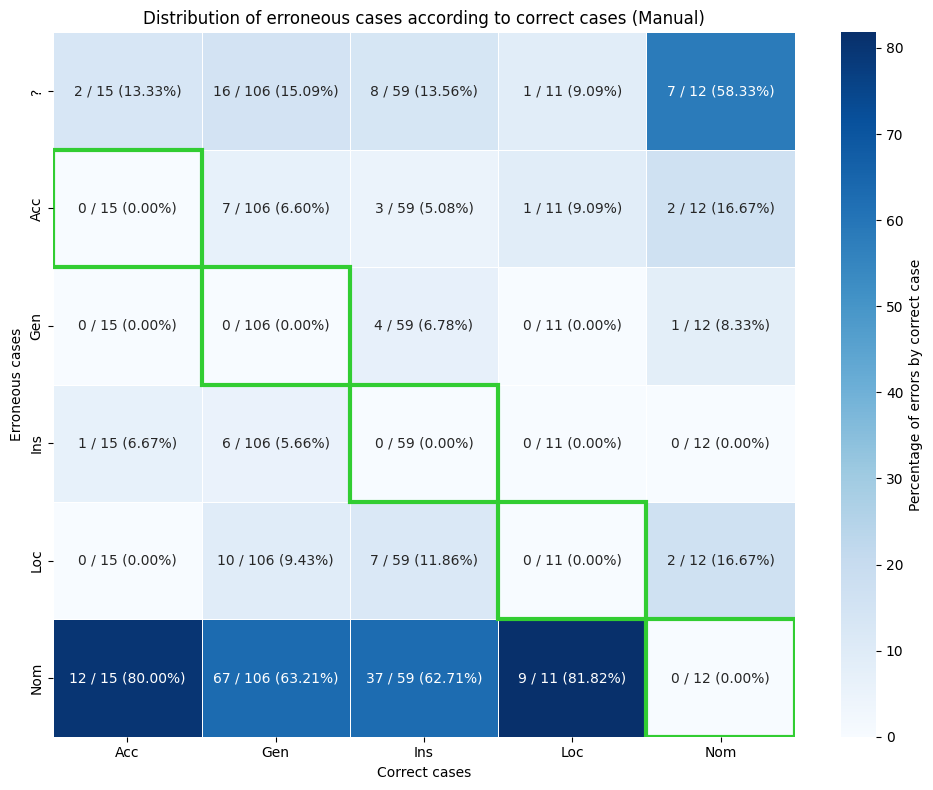

In [5]:
# Tableau de fréquences (colonnes = cas corrects, lignes = cas erronés)
statistiques_corr = df_filtre.groupby(['cas', 'cas correct']).size().unstack(fill_value=0)

# Totaux par colonne (cas corrects)
totaux_colonnes = statistiques_corr.sum(axis=0)

# Pourcentages calculés pour chaque colonne
statistiques_corr_percent = statistiques_corr.div(totaux_colonnes, axis=1) * 100

# Création des annotations : "valeur / total (xx.xx%)"
annotations = statistiques_corr.copy().astype(str)
for i in statistiques_corr.index:
    for j in statistiques_corr.columns:
        valeur = statistiques_corr.loc[i, j]
        total = totaux_colonnes[j]
        pourcent = statistiques_corr_percent.loc[i, j]
        annotations.loc[i, j] = f"{valeur} / {total} ({pourcent:.2f}%)"

# Nombre total d'exemples
total_global = statistiques_corr.values.sum()
print(f"Nombre total d'exemples (global) : {total_global}")

# Création de la heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    statistiques_corr_percent,
    annot=annotations,
    fmt='',
    cmap='Blues',
    cbar_kws={'label': 'Percentage of errors by correct case'},
    linewidths=0.5
)

# Ajout de cadres verts sur la diagonale correcte (si elle existe)
for i, ligne in enumerate(statistiques_corr.index):
    if ligne in statistiques_corr.columns:
        j = list(statistiques_corr.columns).index(ligne)
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='limegreen', lw=3))

# Esthétique
plt.title("Distribution of erroneous cases according to correct cases (Manual)")
plt.xlabel("Correct cases")
plt.ylabel("Erroneous cases")
plt.tight_layout()
plt.savefig("images/heatmap_déclinaison_corrigé_par_cas_correct.png", dpi=300)
plt.show()

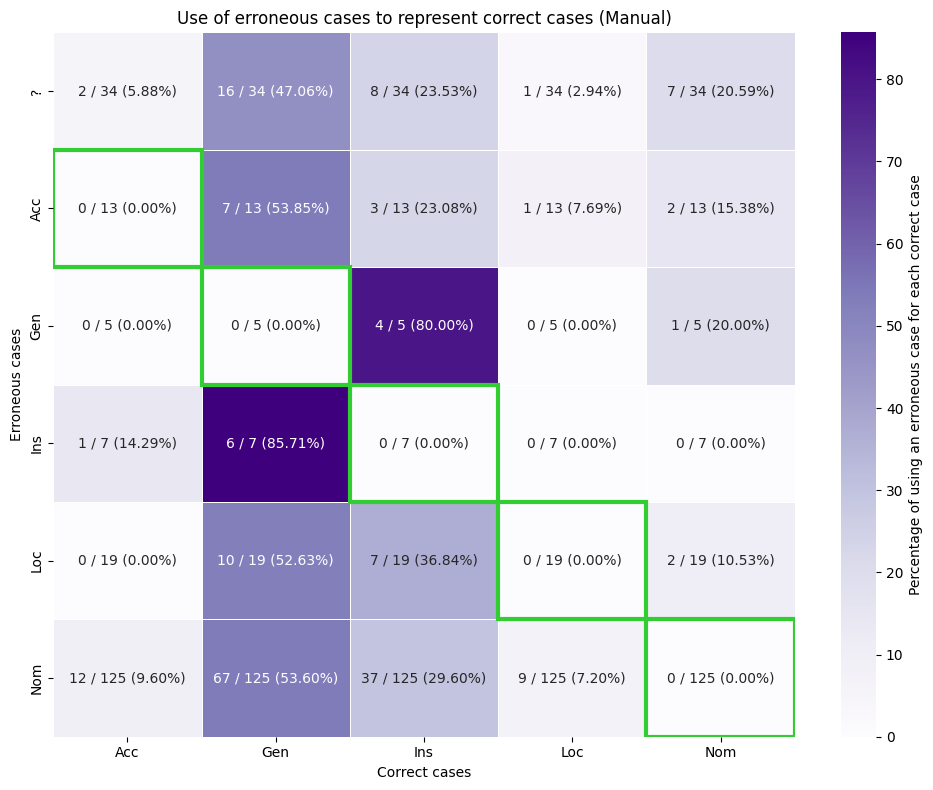

In [6]:
# Tableau demandé : lignes = cas erronés, colonnes = cas corrects
statistiques_cas_errone = df_filtre.groupby(['cas', 'cas correct']).size().unstack(fill_value=0)

# Totaux par ligne (cas erroné)
totaux_lignes = statistiques_cas_errone.sum(axis=1)

# Pourcentages par ligne
statistiques_cas_errone_percent = statistiques_cas_errone.div(totaux_lignes, axis=0) * 100

# Création des annotations : "valeur / total (xx.xx%)"
annotations_finales = statistiques_cas_errone.copy().astype(str)
for i in statistiques_cas_errone.index:
    for j in statistiques_cas_errone.columns:
        valeur = statistiques_cas_errone.loc[i, j]
        total = totaux_lignes[i]
        pourcent = statistiques_cas_errone_percent.loc[i, j]
        annotations_finales.loc[i, j] = f"{valeur} / {total} ({pourcent:.2f}%)"

# Création de la heatmap
plt.figure(figsize=(10, 8))
ax3 = sns.heatmap(
    statistiques_cas_errone_percent,
    annot=annotations_finales,
    fmt='',
    cmap='Purples',
    cbar_kws={'label': 'Percentage of using an erroneous case for each correct case'},
    linewidths=0.5
)

# Ajout de cadres verts sur la diagonale correcte (si elle existe)
for i, ligne in enumerate(statistiques_cas_errone.index):
    if ligne in statistiques_cas_errone.columns:
        j = list(statistiques_cas_errone.columns).index(ligne)
        ax3.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='limegreen', lw=3))

# Esthétique
plt.title("Use of erroneous cases to represent correct cases (Manual)")
plt.xlabel("Correct cases")
plt.ylabel("Erroneous cases")
plt.tight_layout()
plt.savefig("images/heatmap_déclinaison_par_cas_erroné_ligne.png", dpi=300)
plt.show()


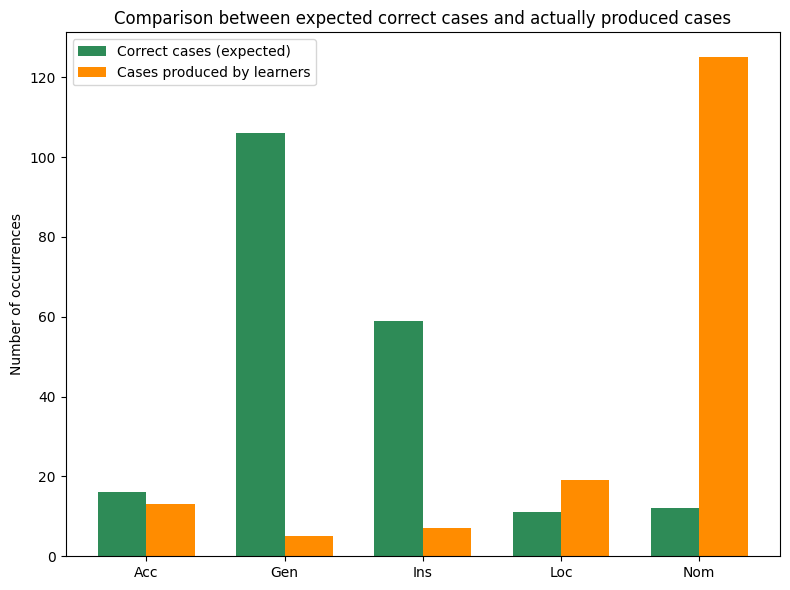

In [7]:
# Comptage des cas corrects (attendus)
cas_corrects = df_filtre['cas correct'].value_counts()

# Comptage des cas utilisés par les apprenants
cas_utilises = df_filtre['cas'].value_counts()

# Fusion des deux comptages
tous_les_cas = sorted(set(cas_corrects.index).union(set(cas_utilises.index)))
df = pd.DataFrame(index=tous_les_cas)
df['Cas corrects (attendus)'] = cas_corrects
df['Cas produits par les apprenants'] = cas_utilises
df = df.fillna(0).astype(int)

# Exclure les cas inconnus ("?")
df = df[df.index != "?"]

# Création du diagramme à barres groupées
x = range(len(df.index))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))

# Barres côte à côte
ax.bar([i - width/2 for i in x], df['Cas corrects (attendus)'], width, label='Correct cases (expected)', color='seagreen')
ax.bar([i + width/2 for i in x], df['Cas produits par les apprenants'], width, label='Cases produced by learners', color='darkorange')

# Étiquettes
ax.set_xticks(x)
ax.set_xticklabels(df.index)
ax.set_ylabel('Number of occurrences')
ax.set_title('Comparison between expected correct cases and actually produced cases')
ax.legend()
plt.tight_layout()
plt.savefig('images/comparaison_cas_attendus_vs_produits.png', dpi=300)
plt.show()


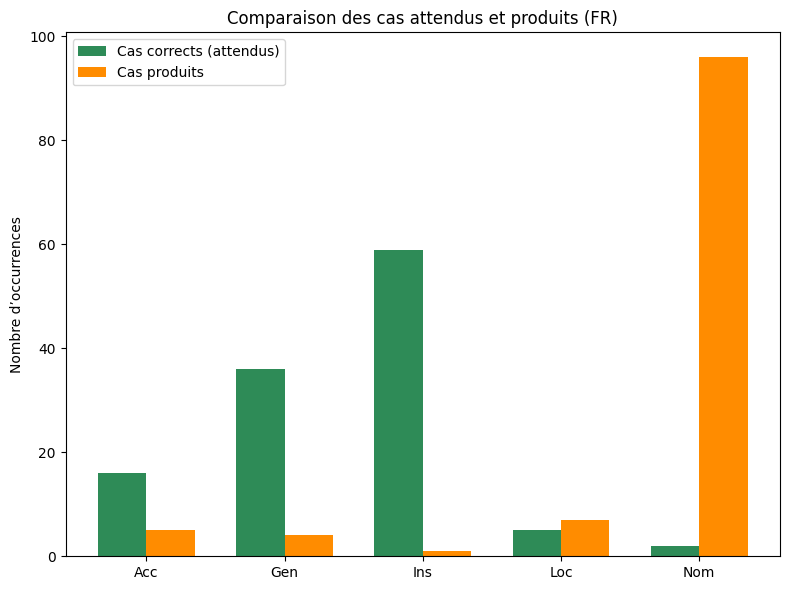

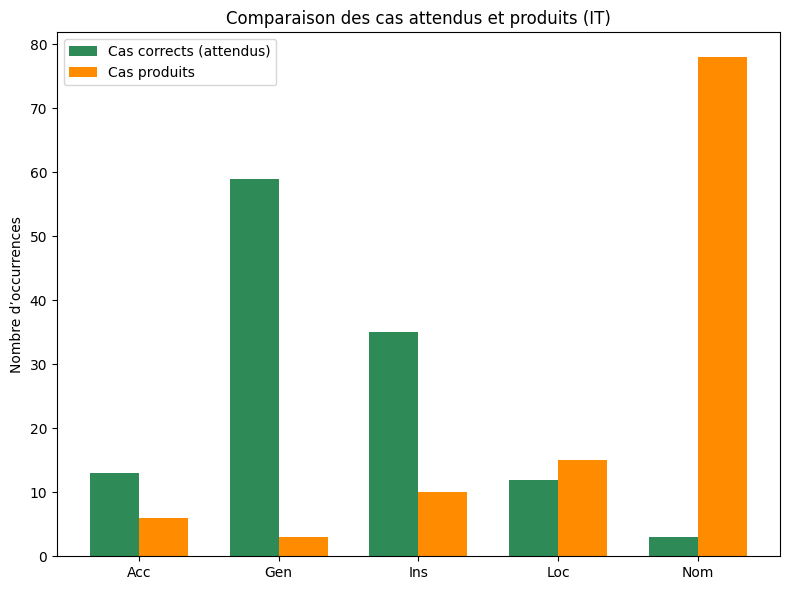

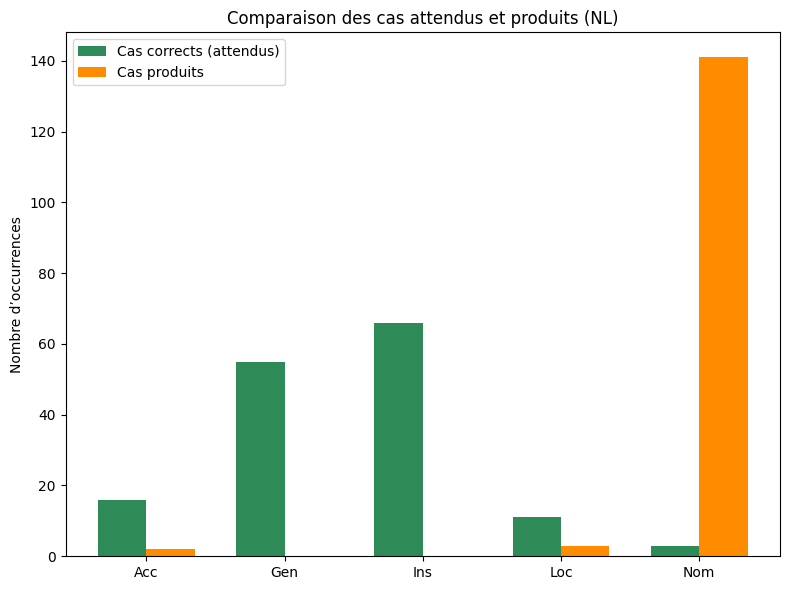

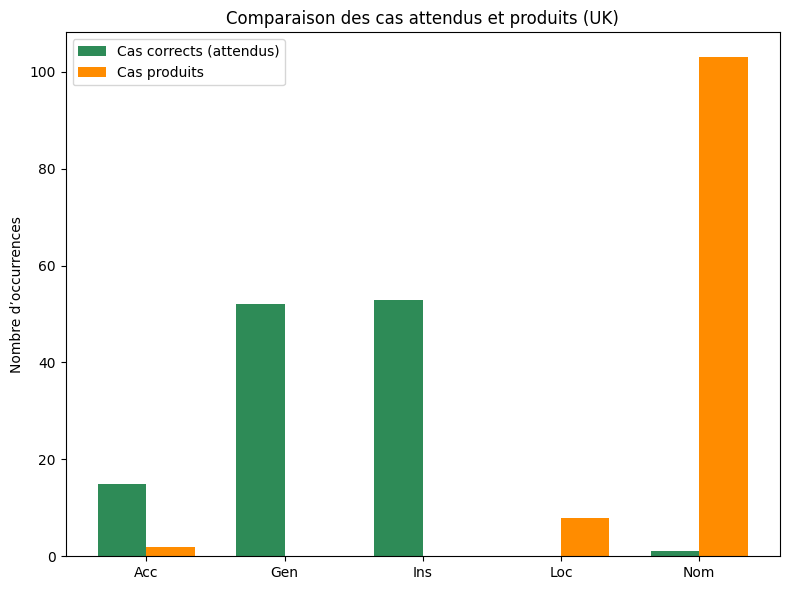

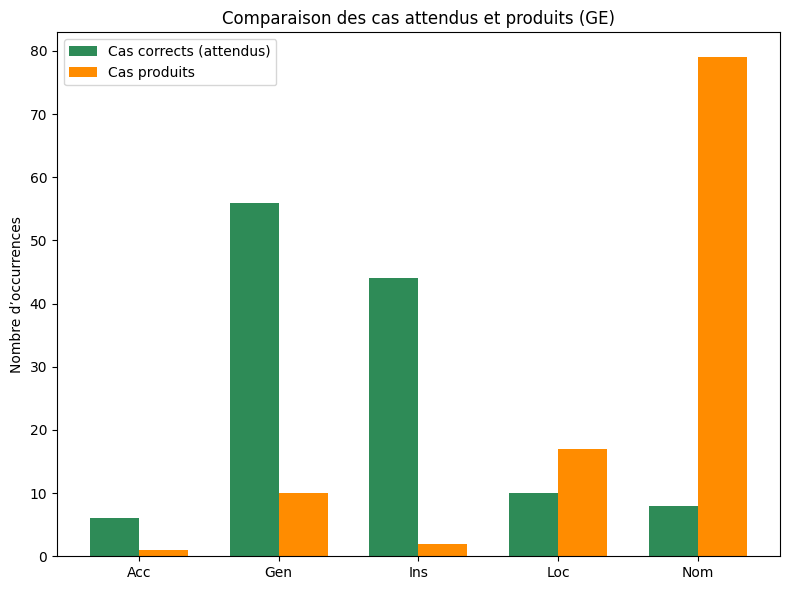

In [8]:
# Liste des pays à traiter
pays_list = ['FR', 'IT', 'NL', 'UK', 'GE']

# Création des graphiques pour chaque pays
for pays in pays_list:
    if pays not in df_filtre.columns:
        continue  # Sauter si colonne manquante

    # Ponderation des cas corrects (attendus)
    cas_corrects = df_filtre.groupby('cas correct')[pays].sum()

    # Ponderation des cas produits
    cas_utilises = df_filtre.groupby('cas')[pays].sum()

    # Fusion des deux séries
    tous_les_cas = sorted(set(cas_corrects.index).union(set(cas_utilises.index)))
    df = pd.DataFrame(index=tous_les_cas)
    df['Cas corrects (attendus)'] = cas_corrects
    df['Cas produits par les apprenants'] = cas_utilises
    df = df.fillna(0).astype(int)

    # Exclusion des cas inconnus
    df = df[df.index != "?"]

    # Création du diagramme à barres
    x = range(len(df.index))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar([i - width/2 for i in x], df['Cas corrects (attendus)'], width,
           label='Cas corrects (attendus)', color='seagreen')
    ax.bar([i + width/2 for i in x], df['Cas produits par les apprenants'], width,
           label='Cas produits', color='darkorange')

    ax.set_xticks(x)
    ax.set_xticklabels(df.index)
    ax.set_ylabel('Nombre d’occurrences')
    ax.set_title(f'Comparaison des cas attendus et produits ({pays})')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'images/comparaison_cas_attendus_vs_produits_{pays}.png', dpi=300)
    plt.show()

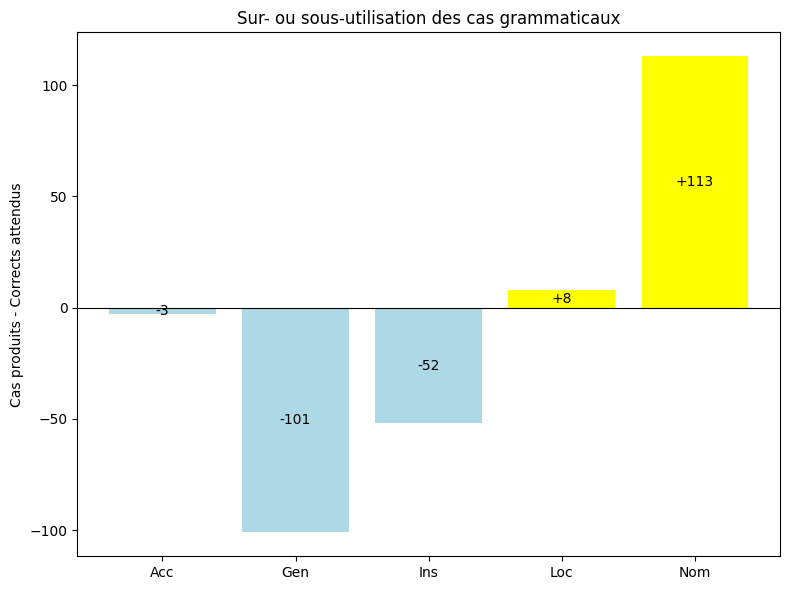

In [9]:
# Comptage des cas corrects
cas_corrects = df_filtre['cas correct'].value_counts()

# Comptage des cas produits
cas_utilises = df_filtre['cas'].value_counts()

# Fusion des deux comptages
tous_les_cas = sorted(set(cas_corrects.index).union(set(cas_utilises.index)))
df_comparaison = pd.DataFrame(index=tous_les_cas)
df_comparaison['Corrects attendus'] = cas_corrects
df_comparaison['Cas produits'] = cas_utilises
df_comparaison = df_comparaison.fillna(0).astype(int)

# Exclusion du cas "?"
df_comparaison = df_comparaison[df_comparaison.index != "?"]

# Inversion de la différence (Cas produits - Corrects attendus)
df_comparaison['Différence'] = df_comparaison['Cas produits'] - df_comparaison['Corrects attendus']
colors = df_comparaison['Différence'].apply(lambda x: 'yellow' if x > 0 else 'lightblue')

# Création du graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(df_comparaison.index, df_comparaison['Différence'], color=colors)

# Ajout des annotations au centre des barres
for bar in bars:
    height = bar.get_height()
    center_y = height / 2 if height > 0 else height / 2
    plt.annotate(
        f'{int(height):+}',
        xy=(bar.get_x() + bar.get_width() / 2, center_y),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

# Esthétique
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Cas produits - Corrects attendus")
plt.title("Sur- ou sous-utilisation des cas grammaticaux")
plt.tight_layout()
plt.savefig("images/sur_sous_utilisation_cas.png", dpi=300)
plt.show()


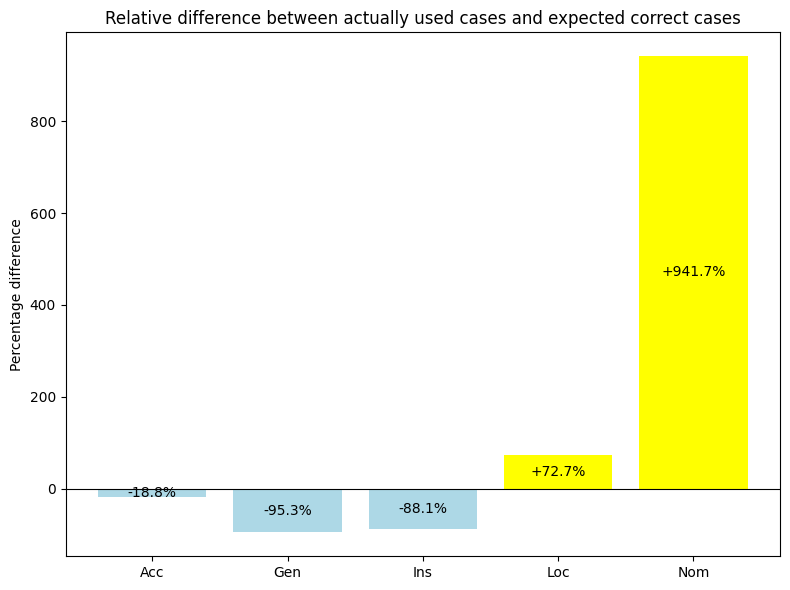


Tableau comparatif des cas :

     Corrects attendus  Cas produits  Différence (%)
Acc                 16            13          -18.75
Gen                106             5          -95.28
Ins                 59             7          -88.14
Loc                 11            19           72.73
Nom                 12           125          941.67


In [10]:
# Comptage des cas corrects
cas_corrects = df_filtre['cas correct'].value_counts()

# Comptage des cas produits
cas_utilises = df_filtre['cas'].value_counts()

# Fusion des deux comptages
tous_les_cas = sorted(set(cas_corrects.index).union(set(cas_utilises.index)))
df_comparaison = pd.DataFrame(index=tous_les_cas)
df_comparaison['Corrects attendus'] = cas_corrects
df_comparaison['Cas produits'] = cas_utilises
df_comparaison = df_comparaison.fillna(0).astype(int)

# Exclusion du cas "?"
df_comparaison = df_comparaison[df_comparaison.index != "?"]

# Calcul de la différence absolue (dans l'autre sens)
df_comparaison['Différence'] = df_comparaison['Cas produits'] - df_comparaison['Corrects attendus']

# Calcul du pourcentage de différence
attendus = df_comparaison['Corrects attendus'].replace(0, pd.NA)
produits = df_comparaison['Cas produits']
diff_pct = ((produits - attendus) / attendus) * 100

df_comparaison['Différence (%)'] = diff_pct.fillna(0).astype('float64').round(2)

# Couleurs des barres
colors_pct = df_comparaison['Différence (%)'].apply(lambda x: 'yellow' if x > 0 else 'lightblue')

# Création du graphique
plt.figure(figsize=(8, 6))
bars_pct = plt.bar(df_comparaison.index, df_comparaison['Différence (%)'], color=colors_pct)

# Ajout des annotations au centre des barres
for bar in bars_pct:
    height = bar.get_height()
    center_y = height / 2 if height != 0 else 0
    plt.annotate(
        f'{height:+.1f}%',
        xy=(bar.get_x() + bar.get_width() / 2, center_y),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

# Esthétique
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Percentage difference")
plt.title("Relative difference between actually used cases and expected correct cases")
plt.tight_layout()
plt.savefig("images/différence_cas_produits_vs_attendus_pourcentage.png", dpi=300)
plt.show()

# Affichage du tableau
print("\nTableau comparatif des cas :\n")
print(df_comparaison[['Corrects attendus', 'Cas produits', 'Différence (%)']])


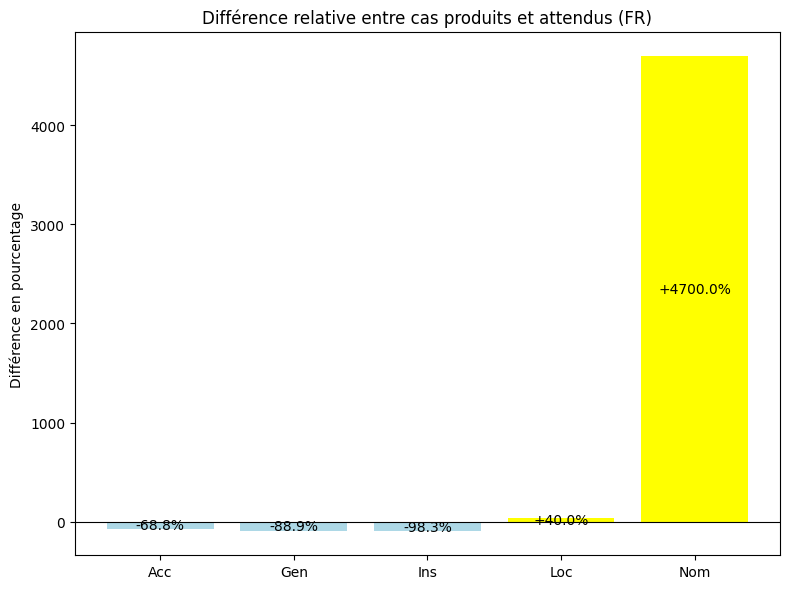


Tableau comparatif des cas pour FR :

     Corrects attendus  Cas produits  Différence (%)
Acc                 16             5          -68.75
Gen                 36             4          -88.89
Ins                 59             1          -98.31
Loc                  5             7           40.00
Nom                  2            96         4700.00


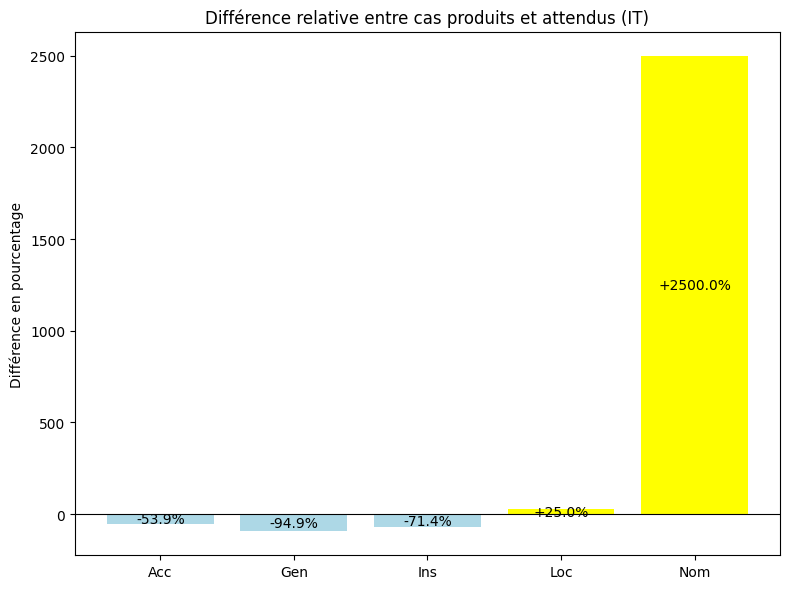


Tableau comparatif des cas pour IT :

     Corrects attendus  Cas produits  Différence (%)
Acc                 13             6          -53.85
Gen                 59             3          -94.92
Ins                 35            10          -71.43
Loc                 12            15           25.00
Nom                  3            78         2500.00


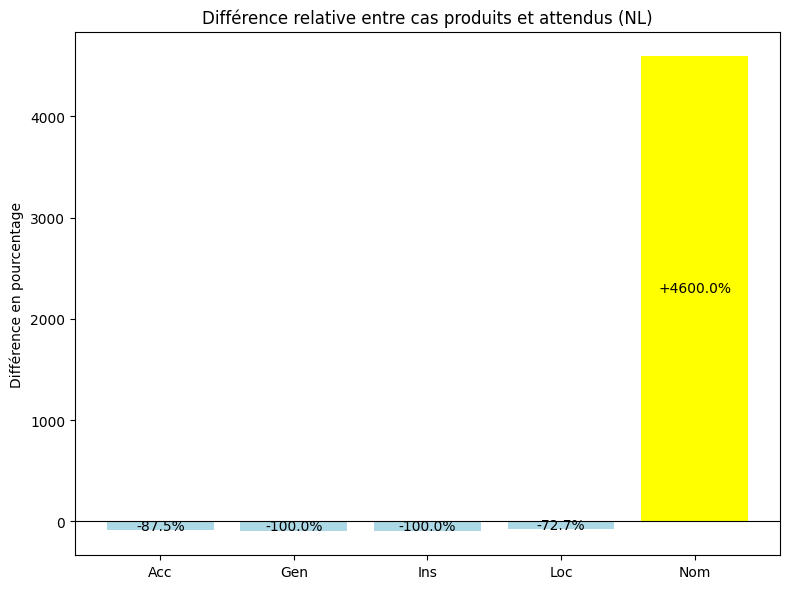


Tableau comparatif des cas pour NL :

     Corrects attendus  Cas produits  Différence (%)
Acc                 16             2          -87.50
Gen                 55             0         -100.00
Ins                 66             0         -100.00
Loc                 11             3          -72.73
Nom                  3           141         4600.00


/tmp/ipykernel_3056/291486025.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_comparaison['Différence (%)'] = diff_pct.fillna(0).astype('float64').round(2)


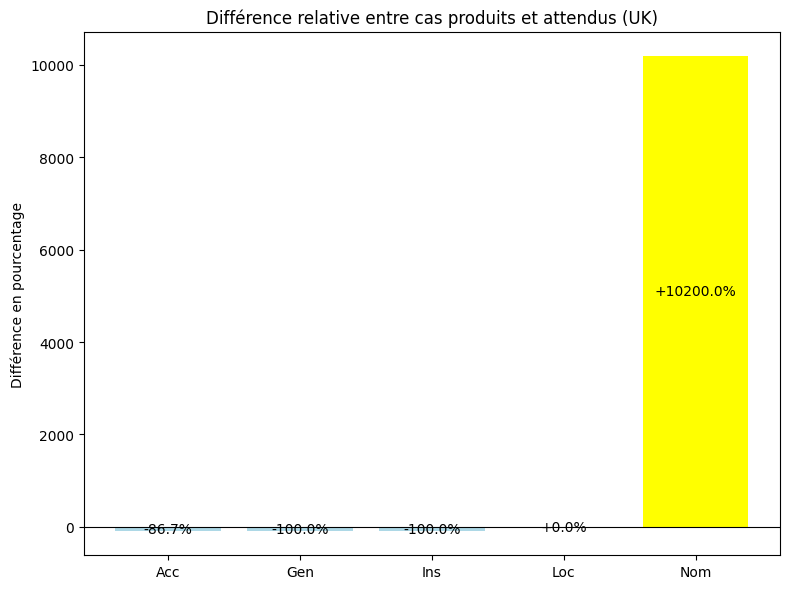


Tableau comparatif des cas pour UK :

     Corrects attendus  Cas produits  Différence (%)
Acc                 15             2          -86.67
Gen                 52             0         -100.00
Ins                 53             0         -100.00
Loc                  0             8            0.00
Nom                  1           103        10200.00


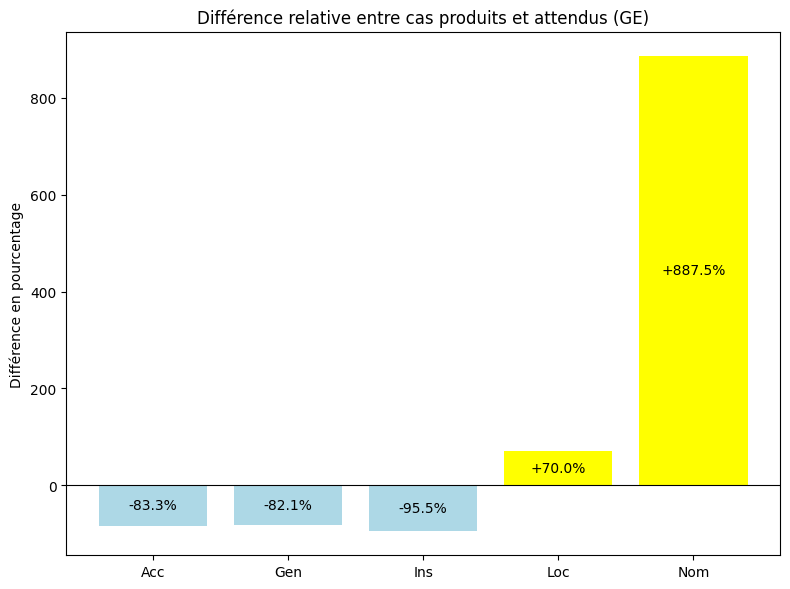


Tableau comparatif des cas pour GE :

     Corrects attendus  Cas produits  Différence (%)
Acc                  6             1          -83.33
Gen                 56            10          -82.14
Ins                 44             2          -95.45
Loc                 10            17           70.00
Nom                  8            79          887.50


In [34]:
# Liste des pays à traiter
pays_list = ['FR', 'IT', 'NL', 'UK', 'GE']

for pays in pays_list:
    if pays not in df_filtre.columns:
        print(f"Colonne manquante pour le pays : {pays}")
        continue

    # Comptage pondéré des cas corrects
    cas_corrects = df_filtre.groupby('cas correct')[pays].sum()

    # Comptage pondéré des cas produits
    cas_utilises = df_filtre.groupby('cas')[pays].sum()

    # Fusion des deux comptages
    tous_les_cas = sorted(set(cas_corrects.index).union(set(cas_utilises.index)))
    df_comparaison = pd.DataFrame(index=tous_les_cas)
    df_comparaison['Corrects attendus'] = cas_corrects
    df_comparaison['Cas produits'] = cas_utilises
    df_comparaison = df_comparaison.fillna(0).astype(int)

    # Exclusion du cas "?"
    df_comparaison = df_comparaison[df_comparaison.index != "?"]

    # Calcul de la différence
    df_comparaison['Différence'] = df_comparaison['Cas produits'] - df_comparaison['Corrects attendus']

    # Calcul du pourcentage de différence
    attendus = df_comparaison['Corrects attendus'].replace(0, pd.NA)
    produits = df_comparaison['Cas produits']
    diff_pct = ((produits - attendus) / attendus) * 100
    df_comparaison['Différence (%)'] = diff_pct.fillna(0).astype('float64').round(2)

    # Couleurs
    colors_pct = df_comparaison['Différence (%)'].apply(lambda x: 'yellow' if x > 0 else 'lightblue')

    # Création du graphique
    plt.figure(figsize=(8, 6))
    bars_pct = plt.bar(df_comparaison.index, df_comparaison['Différence (%)'], color=colors_pct)

    # Ajout des annotations
    for bar in bars_pct:
        height = bar.get_height()
        center_y = height / 2 if height != 0 else 0
        plt.annotate(
            f'{height:+.1f}%',
            xy=(bar.get_x() + bar.get_width() / 2, center_y),
            xytext=(0, 0),
            textcoords="offset points",
            ha='center',
            va='center',
            fontsize=10,
            color='black'
        )

    # Esthétique
    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel("Différence en pourcentage")
    plt.title(f"Différence relative entre cas produits et attendus ({pays})")
    plt.tight_layout()
    plt.savefig(f"images/différence_cas_produits_vs_attendus_{pays}.png", dpi=300)
    plt.show()

    # Affichage du tableau
    print(f"\nTableau comparatif des cas pour {pays} :\n")
    print(df_comparaison[['Corrects attendus', 'Cas produits', 'Différence (%)']])

In [35]:
# === HEATMAP PAR PAYS avec annotations complètes ===
pays_list = ['FR', 'IT', 'NL', 'UK', 'GE']
pays_disponibles = [p for p in pays_list if p in df_filtre.columns]

for pays in pays_disponibles:
    # Groupement pondéré par la fréquence pour chaque pays
    stat_pays = df_filtre.groupby(['cas', 'cas correct'])[pays].sum().unstack(fill_value=0)

    # Total par ligne
    totaux_lignes = stat_pays.sum(axis=1)

    # Pourcentages
    stat_pays_percent = stat_pays.div(totaux_lignes, axis=0) * 100

    # Création des annotations "val / total (xx.xx%)"
    annotations = stat_pays.copy().astype(str)
    for i in stat_pays.index:
        for j in stat_pays.columns:
            val = stat_pays.loc[i, j]
            total = totaux_lignes[i]
            pourcent = stat_pays_percent.loc[i, j]
            annotations.loc[i, j] = f"{val} / {total} ({pourcent:.2f}%)"

#    # Création de la heatmap
#    plt.figure(figsize=(10, 8))
#    sns.heatmap(
#        stat_pays_percent,
#        annot=annotations,
#        fmt='',
#        cmap='YlGnBu',
#        cbar_kws={'label': f'Pourcentage ({pays})'},
#        linewidths=0.5
#    )
#    plt.title(f'Attribution des cas incorrects aux cas corrects ({pays})')
#    plt.xlabel('Cas corrects')
#   plt.ylabel('Cas incorrects')
#    plt.tight_layout()
#    plt.savefig(f'images/heatmap_déclinaison_corrigé_{pays}.png', dpi=300)
#    plt.show()


In [36]:
# Liste des pays
pays_list = ['FR', 'IT', 'NL', 'UK', 'GE']

# Filtr : uniquement les erreurs (cas incorrect ≠ cas correct)
df_erreurs_seulement = df_filtre[df_filtre['cas'] != df_filtre['cas correct']]

# Calcul des erreurs par pays
erreurs_par_pays = {pays: df_erreurs_seulement[pays].sum() for pays in pays_list if pays in df_erreurs_seulement.columns}

# Affichage
print("Nombre d'erreurs par pays :")
for pays, nb in erreurs_par_pays.items():
    print(f"  - {pays} : {nb}")


Nombre d'erreurs par pays :
  - FR : 118
  - IT : 122
  - NL : 151
  - UK : 121
  - GE : 124


In [37]:
# Enregistrement des cas où spaCy s'est trompé dans un fichier CSV
df_merged[df_merged['correct?'] == False].to_csv('erreurs_spacy_vs_manuel.csv', index=False)

# Création de la matrice de confusion pour visualiser les erreurs de classification
conf_matrix = df_merged.groupby(['cas_spacy', 'cas_manuel']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Nombre d’exemples'}, linewidths=0.5)
plt.title("Confusion entre les cas (spaCy vs manuel)")
plt.xlabel("Cas manuel")
plt.ylabel("Cas spaCy")
plt.savefig("images/heatmap_confusion_spacy_vs_manuel.png", dpi=300)
plt.show()

# --- Rapport complet de classification ---
# Extraction des vraies étiquettes et des prédictions pour le rapport
y_true = df_merged['cas_manuel']
y_pred = df_merged['cas_spacy']

# Supprimer les lignes où il y a des NaN dans y_true ou y_pred
mask_clean = y_true.notna() & y_pred.notna()
y_true_clean = y_true[mask_clean]
y_pred_clean = y_pred[mask_clean]


# Calcul et affichage du rapport de classification avec precision, recall, f1-score
report = classification_report(y_true_clean, y_pred_clean, zero_division=0)
print("Rapport complet de classification :\n")
print(report)

NameError: name 'df_merged' is not defined